# Setup

In [1]:
%matplotlib inline

# Reporter code

This code can be put inside a `reporter.py` and imported by the notebooks.

In [2]:
# -*- coding: utf-8 -*-
from collections import OrderedDict

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import binarize
from sklearn.preprocessing import normalize

from IPython.display import Markdown, display


def roc_curve(expected, proba_predicted, pos_label=None):
    """
    Scikit’s ROC Curve, computing the distance of each point of the
    curve to (0, 1).  This distance is used to decide the best threshold.
    """
    fpr, tpr, threshold = metrics.roc_curve(expected, proba_predicted,
                                            pos_label=pos_label)
    curve = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'threshold': threshold,
                          'distance': np.sqrt(fpr ** 2 + (tpr - 1) ** 2)})
    return curve


def precision_recall_curve(expected, proba_predicted, pos_label=None):
    """
    Scikit’s Precision–Recall curve. The returned |threshold| does not have the
    same size as |precision| and |recall|. I assume it’s valid to append its
    own last element to get the same size.
    """
    precision, recall, threshold = metrics.precision_recall_curve(
        expected, proba_predicted, pos_label=pos_label)
    threshold = np.append(threshold, threshold[-1])
    curve = pd.DataFrame({'precision': precision, 'recall': recall,
                          'threshold': threshold})
    return curve.sort_values(by='recall')


def best_threshold(expected, proba_predicted, pos_label=None):
    """
    Returns the best threshold to binarize |proba_predicted|, determined by
    |threshold| that yields the closest ROC curve’s point to the point (0, 1).
    """
    fpr, tpr, threshold = metrics.roc_curve(expected, proba_predicted,
                                            pos_label=pos_label)
    curve = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'threshold': threshold,
                          'distance': np.sqrt(fpr ** 2 + (tpr - 1) ** 2)})
    return curve['threshold'][np.argmin(curve['distance'])]


def classification_report_table(expected, predicted, digits=4, set_name=None):
    """
    Scikit’s |sklearn.metrics.classification_report| in a Pandas DataFrame.
    """
    str_rep = metrics.classification_report(expected, predicted, digits=digits)
    splitted = str_rep.split('\n')
    result = list()
    for line in splitted[2:4]:
        cols = line.split()
        row = OrderedDict(Set=set_name, Label=cols[0], Precision=cols[1],
                          Recall=cols[2], F1=cols[3], Support=cols[4])
        result.append(pd.DataFrame(row, index=[0]))
    cols = ['Avg/Total'] + splitted[-2].split()[3:]
    row = OrderedDict(Set=set_name, Label=cols[0], Precision=cols[1],
                      Recall=cols[2], F1=cols[3], Support=cols[4])
    df_row = pd.DataFrame(row, index=[0])
    return pd.concat(result + [df_row])


def ks_test(expected, proba_predicted, pos_label=None):
    """
    Computes the Kolmogorov–Smirnov test statistic.
    """
    if pos_label is None:
        pos_label = 1
    _, _, threshold = metrics.roc_curve(expected, proba_predicted,
                                        pos_label=pos_label)
    curve = pd.DataFrame({'expected': expected,
                          'proba_predicted': proba_predicted})
    curve.sort_values(by='proba_predicted')
    cumulative = list()
    total_good = np.sum(curve['expected'] != pos_label)
    total_bad = np.sum(curve['expected'] == pos_label)
    for thresh in threshold:
        bucket = np.where(curve['proba_predicted'] <= thresh)
        labels = curve['expected'].iloc[bucket]
        cumulative.append({'good': np.sum(labels != pos_label) / total_good,
                           'bad': np.sum(labels == pos_label) / total_bad,
                           'threshold': thresh})
    return pd.DataFrame(cumulative).sort_values(by='threshold')


class Reporter(object):
    """
    Reporter can deal with many results for binary classification tasks.
    It will generate reports grouped by type (tables and plots).

    Basic usage:
        reporter = Reporter()
        reporter.put('Train', y_test, y_score)
        reporter.report()

    Available report methods:
        summary()          — Simple summary of the classification scores
        scores()           — Show a table with many scores
        confusion_matrix() – Plot a heat map of the confusion matrix
        roc_curve()        – Plot the ROC curve
        ks_test()          – Plot the Kolmogorov–Smirnov test
        precision_recall() — Plot the Precision–Recall curve
        report()           – All of the above

    The |report()| allows to choose what to show and how. By default, all
    methods are shown:
        reporter.report()

    If a parameter is passed to |report()| it will not show all reports, but
    only those selected:
        reporter.report(summary=True)  # Only the summary will be generated

        reporter.report(confusion_matrix=True, roc_curve=True)

    Separately, some report methods accept parameters.  For instance,
    |confusion_matrix()| can generate a matrix with absolute values and
    normalized values. You may omit the normalized values:
        reporter.confusion_matrix(normalized=False)  # Show absolute values

    To do so through |report()| you may pass it with the |setup| keyword:
        reporter.report(setup={'confusion_matrix': {'normalized': False}})

    The command above will generate all reports but the confusion matrix will
    not have normalized values. To generate only the confusion matrix without
    normalization:
        reporter.report(confusion_matrix=True,
                        setup={'confusion_matrix': {'normalized': False}})

    or simply:
        reporter.confusion_matrix(normalized=False).
    """

    """
    A palette of colors is selected for each |result|.
    """
    PALETTE = [
        ['maroon', 'firebrick', 'red', 'orangered', 'coral', 'chocolate'],
        ['darkgreen', 'forestgreen', 'green', 'limegreen', 'mediumseagreen',
         'lime'],
        ['midnightblue', 'darkblue', 'blue', 'dodgerblue', 'cyan'],
        ['darkgoldenrod', 'darkorange', 'orange', 'gold', 'gold', 'yellow'],
        ['rebeccapurple', 'darkviolet', 'purple', 'blueviolet', 'violet',
         'magenta']]

    """
    List of reports to be generated by |report()|.
    """
    REPORTS = ['summary', 'scores', 'confusion_matrix', 'roc_curve', 'ks_test',
               'precision_recall']

    """
    Markdown title format for each report.
    """
    TITLE_FORMAT = '### {}'

    def __init__(self, digits=4):
        """
        |digits| determine how many decimal digits should appear on the reports
        """
        self.results = dict()
        self.digits = digits

    def _title(self, title):
        display(Markdown(self.TITLE_FORMAT.format(title)))

    def put(self, name, expected, proba_predicted, threshold=None,
            pos_label=None, palette=None):
        """
        Add a result |name| with a binary |expected|,
        and a continuous |proba_predicted|.

        Optionally, you may define a fixed |threshold| for binarizarion or,
        otherwise, it will be computed with |best_threshol()|.

        Set |pos_label| when the positive label is not one.

        Set |palette| like an item of |self.PALETTE| for a custom line colors
        of |name|.
        """
        if threshold is None:
            threshold = best_threshold(expected, proba_predicted)
        row_proba_predicted = proba_predicted.reshape(1, -1)
        predicted = binarize(row_proba_predicted, threshold).reshape(-1, 1)
        self.results[name] = {'expected': expected,
                              'proba_predicted': proba_predicted,
                              'predicted': predicted, 'threshold': threshold,
                              'pos_label': pos_label, 'palette': palette}

    def summary(self):
        """sklearn.metrics.classification_report()"""
        summ = list()
        self._title('Summary')
        for name, result in self.results.items():
            summ.append(classification_report_table(
                result['expected'], result['predicted'],
                digits=self.digits, set_name=name))
        summary = pd.concat(summ).set_index(['Set', 'Label'], drop=True)
        display(summary)
        return summary

    def scores(self, **kwargs):
        """
        Computes several classification scores. You may control which ones to
        compute with these method parameters:
            accuracy            kappa            auc            auc_micro
            auc_macr            auc_weighted     brier          matthews
            fbeta_precision     fbeta_recall     f1_binary      f1_micro
            f1_macro            f1_weighted

        By default, some scores will not be computed.

        Alternatively, you may activate all possible scores with:
            scores(all_=True)  # Either "all_" or "all" should work

        To activate all scores through |report()|:
            report(setup={'scores': {'all': True}})
        """
        def is_enabled(name, default=True):
            """Checks whether keyword |name| is defined and returns it"""
            if ('all' in kwargs and kwargs['all']) or \
               ('all_' in kwargs and kwargs['all_']):
                return True
            if not kwargs and default:
                return True
            return (name in kwargs) and kwargs[name]
        scores = list()
        self._title('Scores')
        for name, result in self.results.items():
            exp, pred = result['expected'], result['predicted']
            proba = result['proba_predicted']
            row = list()
            if is_enabled('accuracy'):
                row.append(('Accuracy', metrics.accuracy_score(exp, pred)))
            if is_enabled('kappa'):
                row.append(('Cohen’s κ', metrics.cohen_kappa_score(exp, pred)))
            if is_enabled('auc'):
                fpr, tpr, _ = metrics.roc_curve(exp, proba,
                                                pos_label=result['pos_label'])
                row.append(('AUROC', metrics.auc(fpr, tpr)))
            if is_enabled('auc_micro', default=False):
                auc = metrics.roc_auc_score(exp, proba, average='micro')
                row.append(('Micro AUROC', auc))
            if is_enabled('auc_macro', default=False):
                auc = metrics.roc_auc_score(exp, proba, average='macro')
                row.append(('Macro AUROC', auc))
            if is_enabled('auc_weighted', default=False):
                auc = metrics.roc_auc_score(exp, proba, average='weighted')
                row.append(('Weighted AUROC', auc))
            if is_enabled('brier'):
                score = metrics.brier_score_loss(exp, proba)
                row.append(('Brier loss', score))
            if is_enabled('matthews'):
                score = metrics.matthews_corrcoef(exp, pred)
                row.append(('Matthews CC', score))
            if is_enabled('fbeta_precision', default=False):
                score = metrics.fbeta_score(exp, pred, beta=0.5)
                row.append(('F-(β=0.5) Precision', score))
            if is_enabled('fbeta_recall', default=False):
                score = metrics.fbeta_score(exp, pred, beta=10)
                row.append(('F-(β=10) Recall', score))
            if is_enabled('f1_binary'):
                score = metrics.f1_score(exp, pred, average='binary')
                row.append(('F1-binary', score))
            if is_enabled('f1_micro', default=False):
                score = metrics.f1_score(exp, pred, average='micro')
                row.append(('F1-micro', score))
            if is_enabled('f1_macro', default=False):
                score = metrics.f1_score(exp, pred, average='macro')
                row.append(('F1-macro', score))
            if is_enabled('f1_weighted'):
                score = metrics.f1_score(exp, pred, average='weighted')
                row.append(('F1-weighted', score))
            scores.append(pd.DataFrame(OrderedDict(row), index=[name]))
        scores_table = pd.concat(scores)
        display(scores_table.round(self.digits))
        return scores_table

    def confusion_matrix(self, normalized=True):
        """
        Plot a heat map of the |sklearn.metrics.confusion_matrix|, with
        absolute numbers, and, if |normalized|, normalized by rows.
        """
        rows = len(self.results)
        cols = 2 if normalized else 1
        fig, ax = plt.subplots(rows, cols, figsize=(2 * cols + cols, 2 * rows))
        if not normalized and rows == 1:
            ax = [ax]
        fig.subplots_adjust(hspace=1)
        row = 0
        self._title('Confusion Matrix')
        for name, result in self.results.items():
            expected, predicted = result['expected'], result['predicted']
            vmax = np.max(np.bincount(expected))
            mat = metrics.confusion_matrix(expected, predicted)
            axis = ax[row][0] if normalized and rows > 1 else ax[row]
            sns.heatmap(mat, annot=True, vmax=vmax, fmt='d', cbar=False,
                        ax=axis)
            axis.set_xlabel('{} Predicted Label'.format(name))
            axis.set_ylabel('{} True Label'.format(name))
            axis.set_title('{} Matrix'.format(name))
            if normalized:
                norm_mat = normalize(mat.astype(np.float64), axis=1, norm='l1')
                axis = ax[row][1] if rows > 1 else ax[row + 1]
                sns.heatmap(norm_mat, vmin=0.0, vmax=1.0, annot=True,
                            fmt='.{}f'.format(self.digits), ax=axis)
                axis.set_xlabel('{} Predicted Label'.format(name))
                axis.set_ylabel('{} True Label'.format(name))
                axis.set_title('{} Normalized Matrix'.format(name))
            row += 1
        plt.tight_layout()
        plt.show()

    def roc_curve(self, **kwargs):
        """
        Plot ROC Curve and compute its AUC.
        It will also draw the distance lines and the threshold cut line.
        """
        _, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
        lw_main, lw_dist, lw_cut = 2, 1.5, 1
        roc, thr = ax
        self._title('ROC Curve Analysis')
        result_index = 0
        for name, result in self.results.items():
            if result['palette']:
                palette = result['palette']
            else:
                palette = self.PALETTE[result_index]
            # Scores
            curve = roc_curve(result['expected'], result['proba_predicted'])
            auc = metrics.auc(curve['fpr'], curve['tpr'])
            fmt = '- {{}} Gini coefficient: {{:.{}f}}'.format(self.digits)
            display(Markdown(fmt.format(name, 2.0 * (auc - 0.5))))
            # First plot
            roc.plot(curve['fpr'], curve['distance'], lw=lw_dist,
                     color=palette[4], linestyle=':',
                     label='{} distance to (0, 1)'.format(name))
            roc.plot(curve['fpr'], curve['tpr'], lw=lw_main, color=palette[2],
                     label='{} ROC Curve (area = {:.2f})'.format(name, auc))
            cut = np.argmin(np.abs(curve['threshold'] - result['threshold']))
            roc.axvline(x=curve['fpr'][cut], lw=lw_cut, color=palette[5],
                        linestyle='-.',
                        label='{} threshold ({:.2f})'.format(
                            name, result['threshold']))
            if result_index == 0:
                roc.plot([0, 1], [0, 1], color='navy', lw=lw_main,
                         linestyle='--')
            roc.set_xlim([0.0, 1.0])
            roc.set_ylim([0.0, 1.05])
            roc.set_xlabel('False Positive Rate')
            roc.set_ylabel('True Positive Rate')
            roc.set_title('{} Receiver Operating Characteristic'.format(name))
            roc.legend(loc='lower right')
            result_index += 1
            # Second plot
            curve.sort_values(by='threshold', inplace=True)
            thr.plot(curve['threshold'], curve['distance'], lw=lw_dist,
                     color=palette[4], linestyle=':',
                     label='{} distance to (0, 1)'.format(name))
            thr.plot(curve['threshold'], curve['fpr'], lw=lw_main,
                     color=palette[4], linestyle='--',
                     label='{} FPR'.format(name))
            thr.plot(curve['threshold'], curve['tpr'], lw=lw_main,
                     color=palette[0], label='{} TPR'.format(name))
            thr.axvline(x=curve['threshold'][cut], lw=lw_cut, color=palette[5],
                        linestyle='-.',
                        label='{} threshold ({:.2f})'.format(
                            name, result['threshold']))
            # thr.set_xlim([0.0, 1.0])
            thr.set_ylim([0.0, 1.05])
            thr.set_xlabel('Threshold')
            thr.set_ylabel('Ratio')
            thr.set_title('FPR, TPR & Distance over Threshold')
            thr.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

    def ks_test(self, **kwargs):
        """
        Plots the Kolmogorov–Smirnov test.
        """
        self._title('Kolmogorov–Smirnov test')
        plt.figure(figsize=(4, 4), dpi=72)
        lw_main, lw_dist = 2, 1.5
        result_index = 0
        for name, result in self.results.items():
            if result['palette']:
                palette = result['palette']
            else:
                palette = self.PALETTE[result_index]
            plt.title('Kolmogorov–Smirnov test')
            plt.ylabel('Cumulative Probability')
            plt.xlabel('X')
            curve = ks_test(result['expected'], result['proba_predicted'],
                            pos_label=result['pos_label'])
            plt.plot(curve['threshold'], curve['good'], lw=lw_main,
                     color=palette[0], linestyle='--',
                     label='{} Good Rate'.format(name))
            plt.plot(curve['threshold'], curve['bad'], lw=lw_main,
                     color=palette[3], linestyle='-',
                     label='{} Bad Rate'.format(name))
            # plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            # Find the maximum distance
            dist = np.abs(curve['bad'] - curve['good'])
            max_dist = np.max(dist)
            cut = np.argmax(dist)
            ymin = curve['bad'][cut]
            ymax = curve['good'][cut]
            if ymin > ymax:
                ymin = curve['good'][cut]
                ymax = curve['bad'][cut]
            thresh_cut = curve['threshold'][cut]
            plt.axvline(x=thresh_cut, lw=lw_dist, color=palette[5],
                        linestyle='-.', ymin=ymin + 0.03, ymax=ymax - 0.03,
                        label='{} K–S statistic ({:.2f})'.format(
                            name, max_dist))
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            fmt = '- {{}} K–S statistic: {{:.{}f}}'.format(self.digits)
            display(Markdown(fmt.format(name, max_dist)))
            result_index += 1
        plt.tight_layout()
        plt.show()

    def precision_recall(self, **kwargs):
        """
        Plots the Precision–Recall Curve.
        """
        self._title('Precision–Recall Curve')
        _, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
        lw_main = 2
        result_index = 0
        for name, result in self.results.items():
            if result['palette']:
                palette = result['palette']
            else:
                palette = self.PALETTE[result_index]
            # First plot
            ax[0].set_title('Precision–Recall')
            ax[0].set_ylabel('Precision')
            ax[0].set_xlabel('Recall')
            curve = precision_recall_curve(
                result['expected'], result['proba_predicted'],
                pos_label=result['pos_label'])
            by_recall = curve.copy().sort_values(by='recall')
            auc = metrics.auc(by_recall['recall'], by_recall['precision'])
            ax[0].plot(curve['recall'], curve['precision'], lw=lw_main,
                       color=palette[1],
                       label='{} Precision–Recall curve (area = {:.2f})'.format(
                           name, auc))
            ax[0].legend(loc='lower left')
            # Second plot
            ax[1].set_title('Precision & Recall over Threshold')
            ax[1].set_ylabel('Precision & Recall')
            ax[1].set_xlabel('Threshold')
            by_thresh = curve.copy().sort_values(by='threshold')
            ax[1].plot(by_thresh['threshold'], by_thresh['precision'], lw=lw_main,
                       color=palette[3], linestyle='--',
                       label='{} Precision'.format(name))
            ax[1].plot(by_thresh['threshold'], by_thresh['recall'], lw=lw_main,
                       color=palette[1],
                       label='{} Recall'.format(name))
            ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            result_index += 1
        plt.tight_layout()
        plt.show()

    def report(self, **kwargs):
        """
        Generate all reports availabe of set up, for each result.
        Simple use:
            reporter = Reporter()
            reporter.put('Train', X, y)
            reporter.report()

        You can pass as parameters which reports should be generated:
            summary
            scores
            confusion_matrix
            roc_curve
            ks_test
            precision_recall

        To generate only scores and confusion_matrix:
            reporter.report(scores=True, confusion_matrix=True)

        Additionally, to compute only AUC and Kappa scores:
            reporter.report(scores=True, confusion_matrix=True,
                            setup={'scores': {'auc': True, 'kappa': True}})

        To do all this and also disable normalized confusion matrix:
            reporter.report(scores=True, confusion_matrix=True,
                            setup={'scores': {'auc': True, 'kappa': True},
                                   'confusion_matrix': {'normalized': False}})
        """
        def is_enabled(name):
            """Checks whether keyword |name| is defined"""
            return (not kwargs) or (name in kwargs) and kwargs[name]
        if not self.results:
            print('No results were added to this Reporter.')
            print('Use reporter.put("Train", y_train, y_score) before.')
            return
        setup = dict()
        if 'setup' in kwargs:
            setup = kwargs['setup']
            del kwargs['setup']
        for name in self.REPORTS:
            if is_enabled(name):
                reporter = getattr(self, name)
                if name in setup:
                    if setup[name]:
                        reporter(**setup[name])
                else:
                    reporter()


def report(proba_predictor, *args, **kwargs):
    """
    Generates a report for a callabe |proba_predictor| for a list of
    data sets.

    Each data set must be represented by a 3-tuple: (set_name, X, y)

    Sketch:
        report(classifier.predict_proba, ('Train', X, y))
        report(classifier.predict_proba, ('Train', X_train, y_train),
                                         ('Test', X_test, y_test))

    Keywords can be passed to control the output:
        report(classifier.predict_proba, ('Train', X, y),
               summary=True,
               scores=True,
               setup={'scores': {'f1_binary': True}})
    """
    reporter = Reporter()
    threshold = None
    for name, X, y in args:
        if not threshold:
            threshold = best_threshold(y, proba_predictor(X))
        reporter.put(name, y, proba_predictor(X), threshold=threshold)
    reporter.report(**kwargs)


/usr/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Train a Binary Classification Model

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

seed = 42

X, y = make_classification(n_samples=10000, n_informative=10, weights=[0.97, 0.03], 
                           flip_y=0.015, random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=seed)

classifier = SVC(kernel='linear', probability=True, random_state=seed)
classifier.fit(X_train, y_train);

# Report

### Summary

Precision  Recall      F1 Support
Set   Label                                      
Train 0            0.9837  0.8250  0.8974    8652
      1            0.1319  0.6609  0.2199     348
      Avg/Total    0.9508  0.8187  0.8712    9000
Test  0            0.9862  0.8145  0.8922     965
      1            0.1182  0.6857  0.2017      35
      Avg/Total    0.9558  0.8100  0.8680    1000

### Scores

,Accuracy,Cohen’s κ,AUROC,Brier loss,Matthews CC,F1-binary,F1-weighted
Train,0.8187,0.1661,0.7719,0.0373,0.2370,0.2199,0.8712
Test,0.8100,0.1510,0.8041,0.0340,0.2286,0.2017,0.8680


### Confusion Matrix

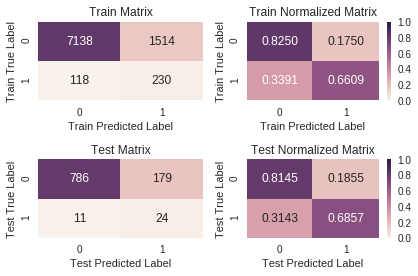

### ROC Curve Analysis

- Train Gini coefficient: 0.5437

- Test Gini coefficient: 0.6081

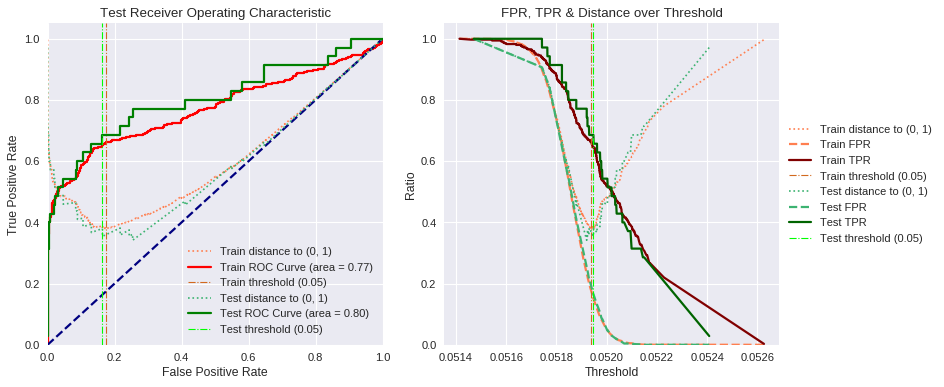

### Kolmogorov–Smirnov test

- Train K–S statistic: 0.5021

- Test K–S statistic: 0.4990

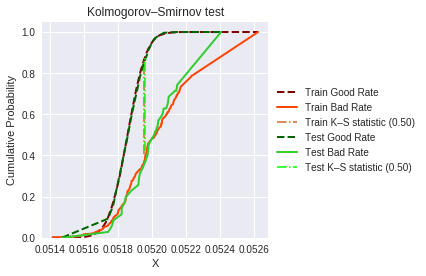

### Precision–Recall Curve

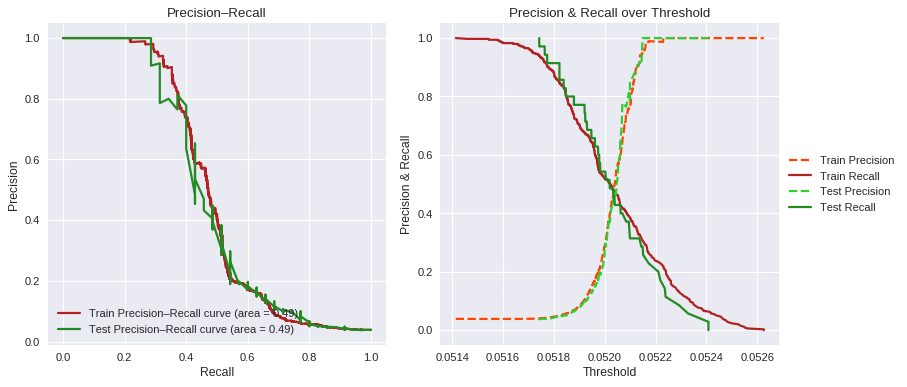

In [4]:
report(lambda X: classifier.predict_proba(X)[:, 1],
       ('Train', X_train, y_train),
       ('Test', X_test, y_test))